In [1]:
# Load the Julia environment needed for this notebook
import Pkg
Pkg.activate("../../Tasks2D")


  Activating project at `~/Developer/research/fall2023/cocosci/tasks2D/Tasks2D`


In [2]:
import LinearAlgebra
import Makie   # Visualization Library
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session
using Gen         # Gen probabilistic programming library
import GenParticleFilters # Additional particle filtering functionality for Gen
import GridWorlds # Simple gridworld functionality
import LineWorlds
const L = LineWorlds
import LineWorlds: cast # Ray caster
import GenPOMDPs  # Beginnings of a Gen POMDP library

import Tasks2D

includet("SLAM/Utils.jl")

In [45]:
import CairoMakie
CairoMakie.activate!()

[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
┌ Warning: Module Makie with build ID fafbfcfd-0759-6f1b-0007-7ad0be47bc99 is missing from the cache.
│ This may mean Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
[ Info: Skipping precompilation since __precompile__(false). Importing CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0].
[ Info: Precompiling Cairo [159f3aea-2a34-519c-b102-8c37f9878175]
┌ Warning: Module Cairo_jll with build ID fafbfcfd-d9b0-506d-0007-7ad6e7964399 is missing from the cache.
│ This may mean Cairo_jll [83423d85-b0ee-5818-9007-b63ccbeb887a] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
[ Info: Skipping precompilation since __precompile__(false). Importing Cairo [159f3aea-2a34-519c-b102-8c37f9878175].
[ Info: Precompiling Pango_jll [36c8627f-9965-5494-a995-c6b170f724f3]
┌ Warning: Module Cairo_jll 

In [5]:
# Initial position model

# Distribution to sample uniformly from a Julia Set
using Tasks2D.Distributions: uniform_from_set

@gen (static) function uniform_agent_pos(t_to_params)
    w = t_to_params(0).map # a map, represented as a GridWorlds.GridWorld
    
    cell ~ uniform_from_set(GridWorlds.empty_cells(w))
    
    # Cell (i, j) corresponds to the region from i-1 to i and j-1 to j
    x ~ uniform(cell[1] - 1, cell[1])
    y ~ uniform(cell[2] - 1, cell[2])
    
    return ([x, y], 0, false)
end

function det_next_pos(pos, a, Δ)
    (x, y) = pos
    a == :up    ? [x, y + Δ] :
    a == :down  ? [x, y - Δ] : 
    a == :left  ? [x - Δ, y] :
    a == :right ? [x + Δ, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end

function handle_wall_intersection(prev, new, gridworld)
    walls = GridWorlds.nonempty_segments(gridworld)
    move = L.Segment(prev, new)
    
    min_collision_dist = Inf
    vec_to_min_dist_collision = nothing
    for i in 1:(size(walls)[1])
        wall = walls[i, :]
        # print("wall: $wall")
        do_intersect, dist = L.Geometry.cast(move, L.Segment(wall))

        if do_intersect && dist ≤ L.Geometry.norm(move)
            if dist < min_collision_dist
                min_collision_dist = dist
                vec_to_min_dist_collision = L.Geometry.diff(move)
            end
        end
    end
    
    if !isnothing(vec_to_min_dist_collision)
        dist = min_collision_dist
        if dist < 0.05
            return (prev, true)
        else
            normalized_vec = (vec_to_min_dist_collision / L.Geometry.norm(vec_to_min_dist_collision))
            collision_pt = prev + (dist - 0.04) * normalized_vec
            return (collision_pt, true)
        end
    end
    
    return (new, false)
end

@gen (static) function motion_model(state, action, t_to_params)
    (a, wall_clock_time) = action
    (pos, t_prev, prev_hit_wall) = state
    params = t_to_params(t_prev + 1)
    w, σ = params.map, params.step.σ
    
    next_pos_det = det_next_pos(pos, a, params.step.Δ)
    noisy_next_pos ~ broadcasted_normal(next_pos_det, params.step.σ)
    (next_pos, hit_wall) = handle_wall_intersection(pos, noisy_next_pos, w)
    
    return (next_pos, t_prev + 1, prev_hit_wall || hit_wall)
end

@gen function observe_noisy_distances(state, t_to_params)
    (pos, t, _) = state
    params = t_to_params(t)

    p = reshape([pos..., params.obs.orientation], (1, 3))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    wall_segs = GridWorlds.wall_segments(params.map)
    strange_segs = GridWorlds.strange_segments(params.map)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.wall_sensor_args
    dists_walls = L.cast(p, wall_segs; num_a=params.obs.n_rays, zmax)
    dists_walls = reshape(dists_walls, (:,))

    w, s_noise, outlier, outlier_vol, zmax = params.obs.strange_sensor_args
    dists_strange = L.cast(p, strange_segs; num_a=params.obs.n_rays, zmax)
    dists_strange = reshape(dists_strange, (:,))

    is_wall_measurement = [w < s for (w, s) in zip(dists_walls, dists_strange)]
    wall_measurements = dists_walls[is_wall_measurement]
    
    σ_wall = params.obs.wall_sensor_args.σ
    noisy_wall_measurements ~ Gen.broadcasted_normal(wall_measurements, s_noise)

    strange_measurements = dists_strange[[!w for w in is_wall_measurement]]
    if !isempty(strange_measurements)
        mins = [params.obs.strange_sensor_args.dist_to_zmin(m) for m in strange_measurements]
        maxs = [params.obs.strange_sensor_args.dist_to_zmax(m) for m in strange_measurements]
        noisy_strange_measurements ~ Utils.mapped_uniform(mins, maxs)
    else
        noisy_strange_measurements = []
    end

    obs = []
    wall_ctr = 1
    strange_ctr = 1
    for i in 1:params.obs.n_rays
        if is_wall_measurement[i]
            push!(obs, noisy_wall_measurements[wall_ctr])
            wall_ctr += 1
        else
            push!(obs, noisy_strange_measurements[strange_ctr])
            strange_ctr += 1
        end
    end
    # dists = min.(dists_walls, dists_strange)
    # dists = reshape(dists, (:,))

    # # get vector of sigmas, to apply to `dists`
    # # params.obs.sensor_args.σ_wall for walls; params.obs.sensor_args.σ_strange for strange
    # # σ_strange = params.obs.strange_sensor_args.σ
    # sigmas = [w < s ? σ_wall : σ_strange for (w, s) in zip(dists_walls, dists_strange)]
    # sigmas = reshape(sigmas, (:,))

    # obs ~ Gen.mvnormal(dists, LinearAlgebra.Diagonal(sigmas))
    return obs
end

# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    observe_noisy_distances, # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#435"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [6]:
function get_posobs_seq(groundtruth_trace)
    return map(
        trace -> (
            [p for (p, t, h) in GenPOMDPs.state_sequence(trace)],
            [reshape(o, (:,)) for o in GenPOMDPs.observation_retval_sequence(trace)]
        ),
        groundtruth_trace
    )
end
function get_obs_seq(groundtruth_trace)
    return map(
        trace -> [reshape(o, (:,)) for o in GenPOMDPs.observation_retval_sequence(trace)],
        groundtruth_trace
    )
end

using Dates

function get_save_tr(tr)
    function save_tr(viz_actions)
        filename = "saves/" * string(now()) * "__pomdp_trace.jld"
        Utils.serialize_trace_and_viz_actions(filename, tr[];
            viz_actions=viz_actions,
            # args_to_serializeable = args -> (args[1:2]..., args[3].params)
        )
    end
    return save_tr
end

function get_take_action(_take_action)
    function take_action(a)
        _take_action((a, Dates.now()))
    end
    return take_action
end
function get_interactive_trace(args...; kwargs...)
    (trace, _take_action) = GenPOMDPs.interactive_world_trace(args...; kwargs...)
    return (trace, get_take_action(_take_action))
end
function make_trace_interactive(args...; kwargs...)
    (trace, _take_action) = GenPOMDPs.make_trace_interactive(args...; kwargs...)
    return (trace, get_take_action(_take_action))
end

function get_did_hitwall_observable(trace)
    return map(trace -> GenPOMDPs.state_sequence(trace)[end][3], trace)
end
function close_window(f)
    glfw_window = GLMakie.to_native(display(f))
    GLMakie.GLFW.SetWindowShouldClose(glfw_window, true)
end

function get_action_times_observable(trace)
    return map(trace -> [t for (a, t) in GenPOMDPs.action_sequence(trace)], trace)
end
function get_timing_args(trace; speedup_factor=1, max_delay=5) # 5 seconds max delay
    return (get_action_times_observable(trace), speedup_factor, max_delay)
end

struct ConstantTToParams
    params
end
(p::ConstantTToParams)(t) = p.params

struct SwitchTToParams
    params1
    params2
    switch
end
(p::SwitchTToParams)(t::Makie.Observable) = p(t[])
(p::SwitchTToParams)(t) = p.switch(t) ? p.params1 : p.params2

struct TimedSwitchTToParams
    params1
    params2
    timewindows_params1
    timewindows_params2
end
(p::TimedSwitchTToParams)(t::Makie.Observable) = p(t[])
function (p::TimedSwitchTToParams)(t)
    for (start, stop) in p.timewindows_params1
        if start ≤ t ≤ stop
            return p.params1
        end
    end
    for (start, stop) in p.timewindows_params2
        if start ≤ t ≤ stop
            return p.params2
        end
    end
    error("No time window found for time $t")
end

struct DistanceToConstant
    c
end
(d::DistanceToConstant)(x) = d.c
struct MultiplyDistanceByConstant
    c
end
(d::MultiplyDistanceByConstant)(x) = 2. + x * d.c

In [58]:
_get_params(map) = (;
    # map = GridWorlds.load_custom_map(5),
    map=map,
    step = (; Δ = .5, σ = 0.005),
    obs = (; fov = 2π, n_rays = 90, orientation = π/2,
        # I think currently only σ is used
        wall_sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0, σ=0.005
        ),

        strange_sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0, σ=5.5,
            dist_to_zmin = DistanceToConstant(1.0),
            dist_to_zmax = MultiplyDistanceByConstant(2.5)
            # min_dist=1.0
            # max_dist=10.0
        )
    )
)

MAP_INTRO = GridWorlds.load_houseexpo_gridworld(24, 1)
MAP_EXPLAIN_STRANGE = GridWorlds.load_custom_map(3)
MAP_W_STRANGE = GridWorlds.load_custom_map(4)
MAP_WOUT_STRANGE = GridWorlds.load_custom_map(5)
MAP2_W_STRANGE = GridWorlds.load_custom_map(6)
MAP2_WOUT_STRANGE = GridWorlds.load_custom_map(7)

T_TO_PARAMS_INTRO = ConstantTToParams(_get_params(MAP_INTRO))
T_TO_PARAMS_EXPLAIN_STRANGE = ConstantTToParams(_get_params(MAP_EXPLAIN_STRANGE))
T_TO_PARAMS_W_STRANGE = ConstantTToParams(_get_params(MAP_W_STRANGE))
T_TO_PARAMS_WOUT_STRANGE = ConstantTToParams(_get_params(MAP_WOUT_STRANGE))
T_TO_PARAMS_LEARN_MAP = T_TO_PARAMS_WOUT_STRANGE

T_TO_PARAMS_TEST1MAP = ConstantTToParams(_get_params(MAP_W_STRANGE))
T_TO_PARAMS_TEST2MAP = ConstantTToParams(_get_params(MAP2_W_STRANGE))

T_TO_PARAMS_TEST = TimedSwitchTToParams(
    _get_params(MAP_W_STRANGE),
    _get_params(MAP_WOUT_STRANGE),
    ((6, Inf),),
    ((-Inf, 6),),
)
T_TO_PARAMS_TEST2 = TimedSwitchTToParams(
    _get_params(MAP2_W_STRANGE),
    _get_params(MAP2_WOUT_STRANGE),
    ((6, Inf),),
    ((-Inf, 6),),
)
# T_TO_PARAMS = ConstantTToParams(_PARAMS)
T_TO_PARAMS_TEST(0);

In [13]:
illustrative_map_str = """
wwwwwwwwwwwwwww
w   w    w    w
w        w    w
w   w    w    w
w   w         w
wwwww         w
wwwww    w    w
w        w    w
w        w    w
w        w    w
wwwwwwwwwwwwwww
"""
illustrative_map = GridWorlds.mapstr_to_gridworld(illustrative_map_str)
illustrative_t_to_params = ConstantTToParams(_get_params(illustrative_map));

In [14]:
world_trace, take_action = get_interactive_trace(
    trajectory_model, illustrative_t_to_params,
    choicemap((GenPOMDPs.state_addr(0, :cell), (3, 3)))  
);

In [23]:
get_posobs_seq(world_trace)[][2]

1-element Vector{Vector{Any}}:
 [1.3658968244869227, 1.3767374597885393, 1.431653715881433, 1.4368046392810245, 1.4338780939617843, 1.514942269117622, 1.535750778404037, 1.5774208596105663, 1.6343730492772992, 1.741440464492813  …  1.7700928458922853, 1.6454533429845597, 1.5746507759971642, 1.554534669599744, 1.4681657500468375, 1.4779846391153346, 1.437396375375948, 1.4191954386500156, 1.4197183749558482, 1.40252132586522]

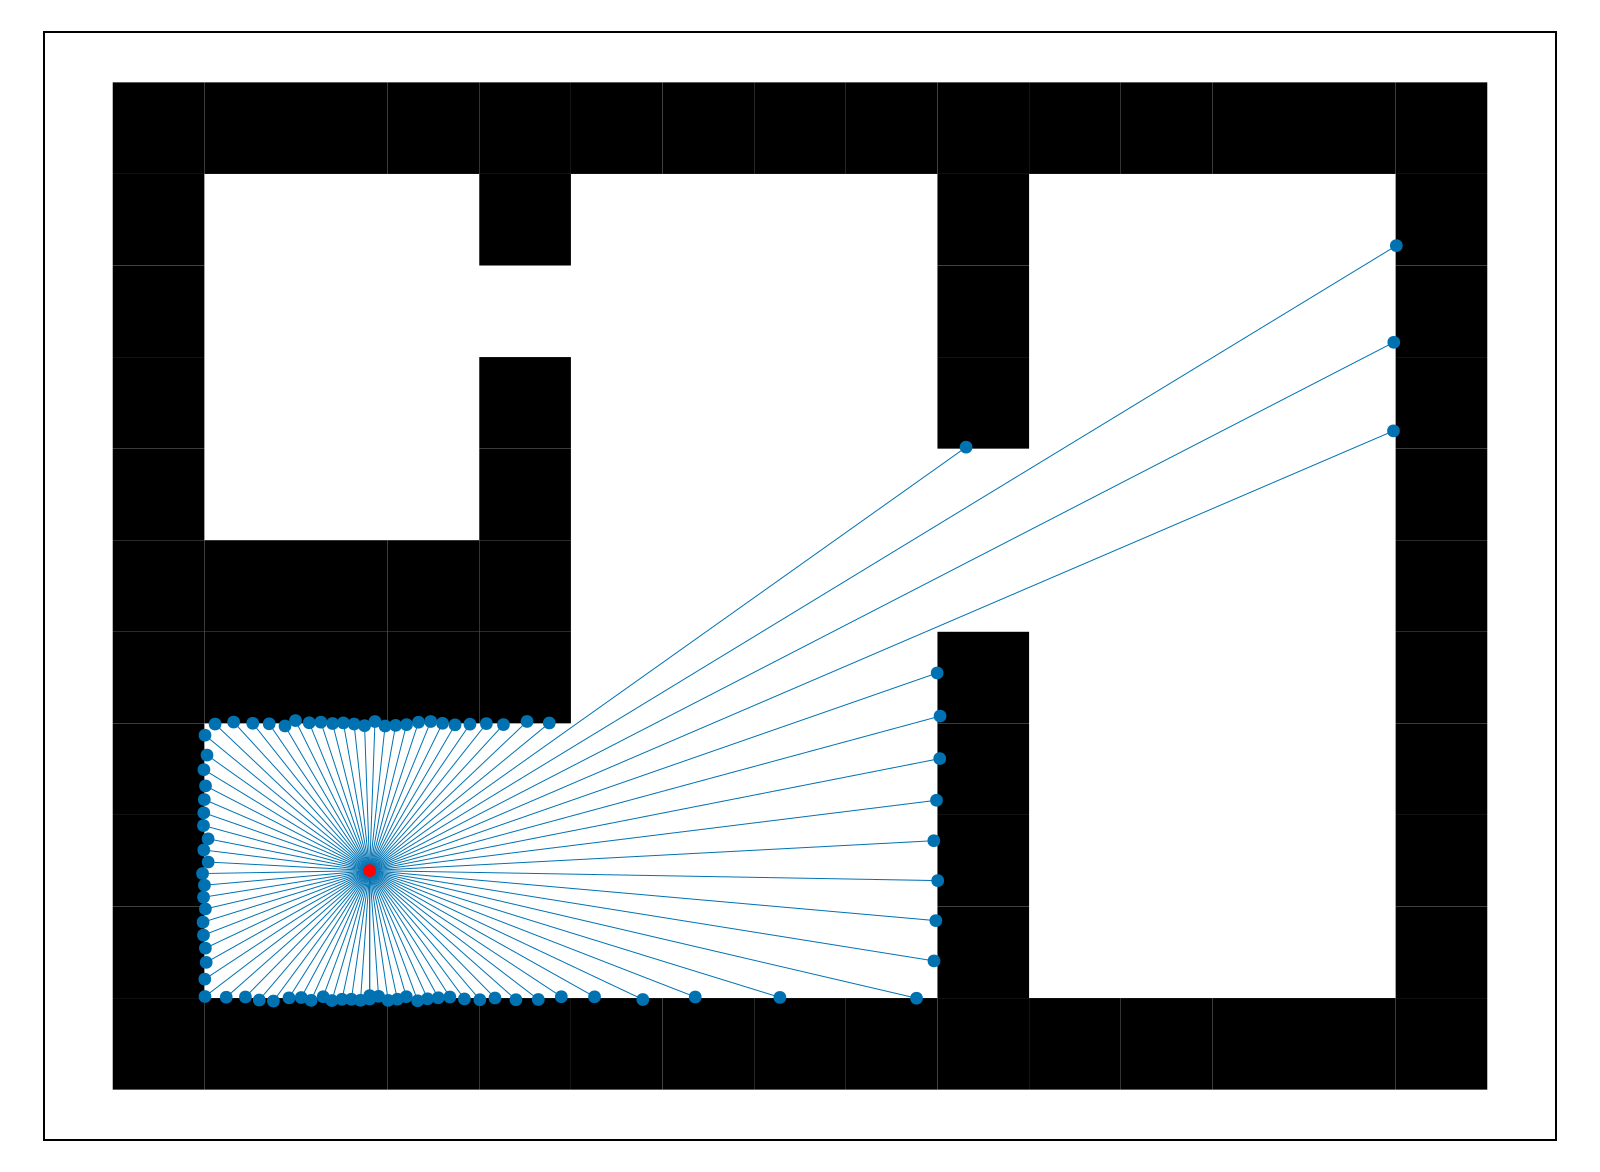

In [48]:
f = GridWorlds.Viz.mapviz_stillframe(
    illustrative_t_to_params(0).map,
    get_posobs_seq(world_trace)[][1][1],
    get_posobs_seq(world_trace)[][2][1],
    show_map=true
)
Makie.save("000_illustrative_map.pdf", f)
f

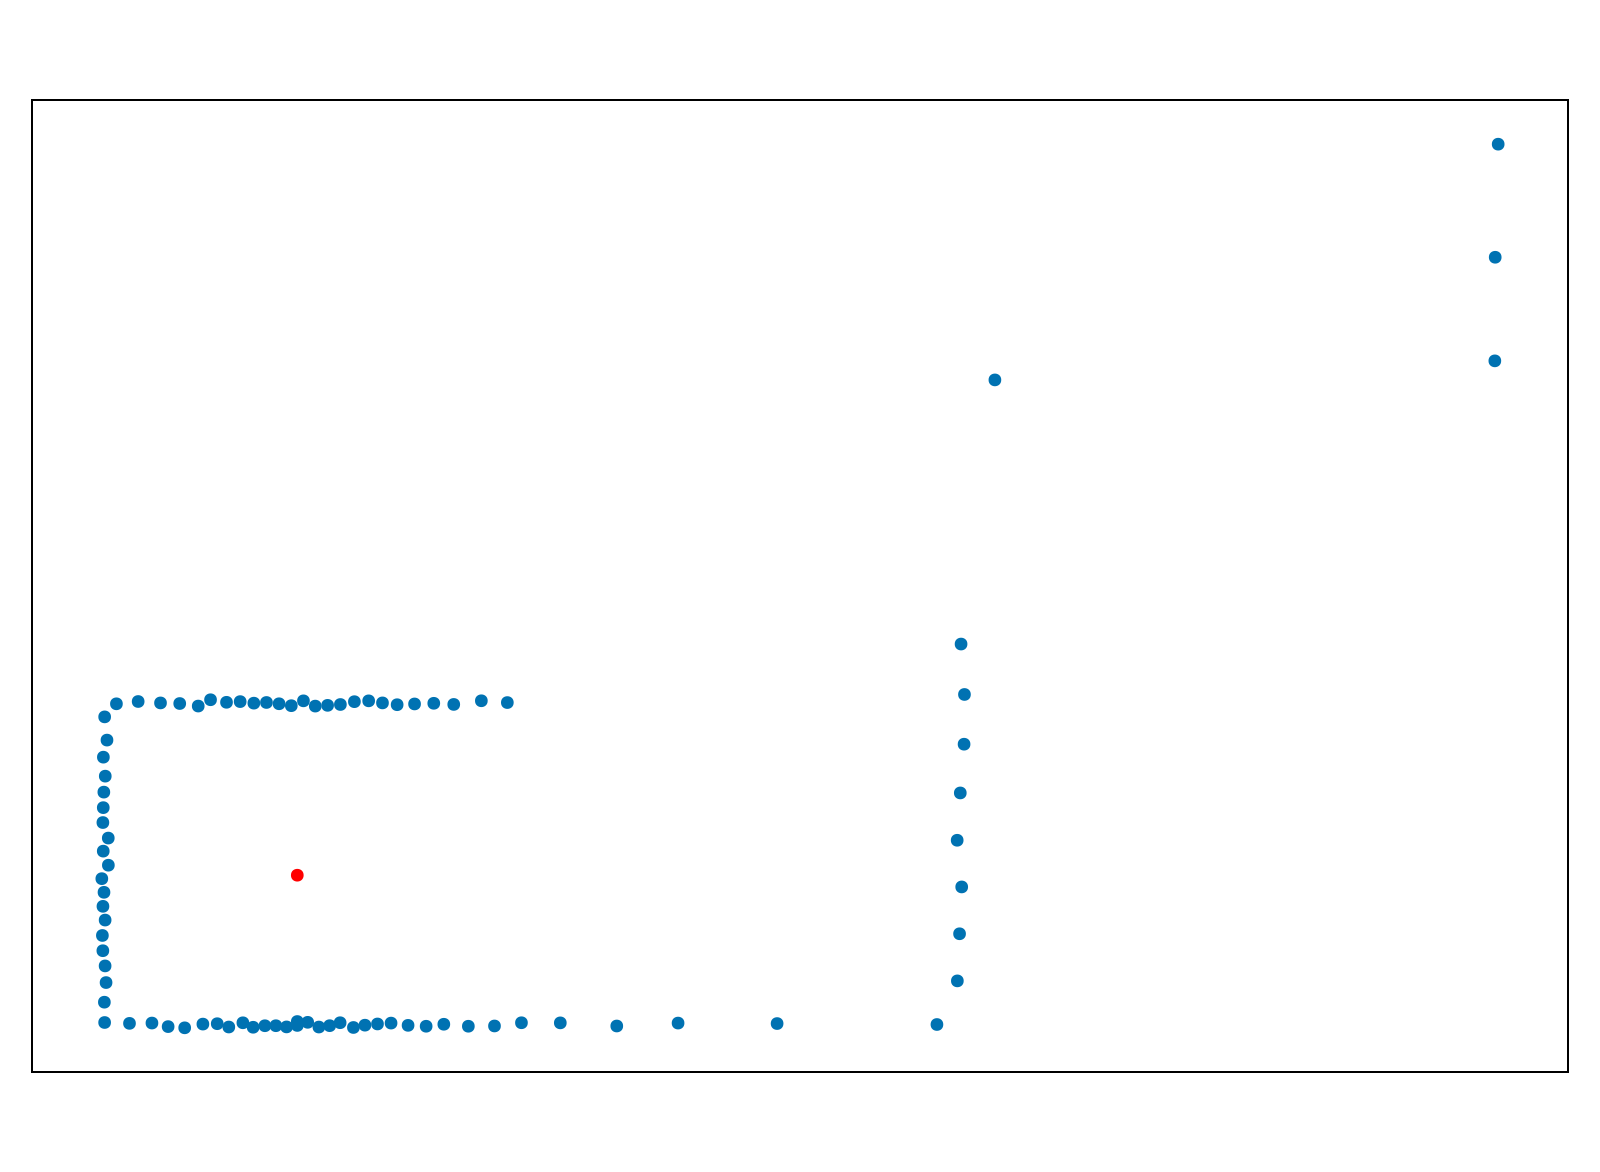

In [84]:
f = GridWorlds.Viz.mapviz_stillframe(
    illustrative_t_to_params(0).map,
    get_posobs_seq(world_trace)[][1][1],
    get_posobs_seq(world_trace)[][2][1],
    show_map=false,
    show_lines_to_walls=false
)
Makie.save("001_illustrative_agent_view.pdf", f)
f

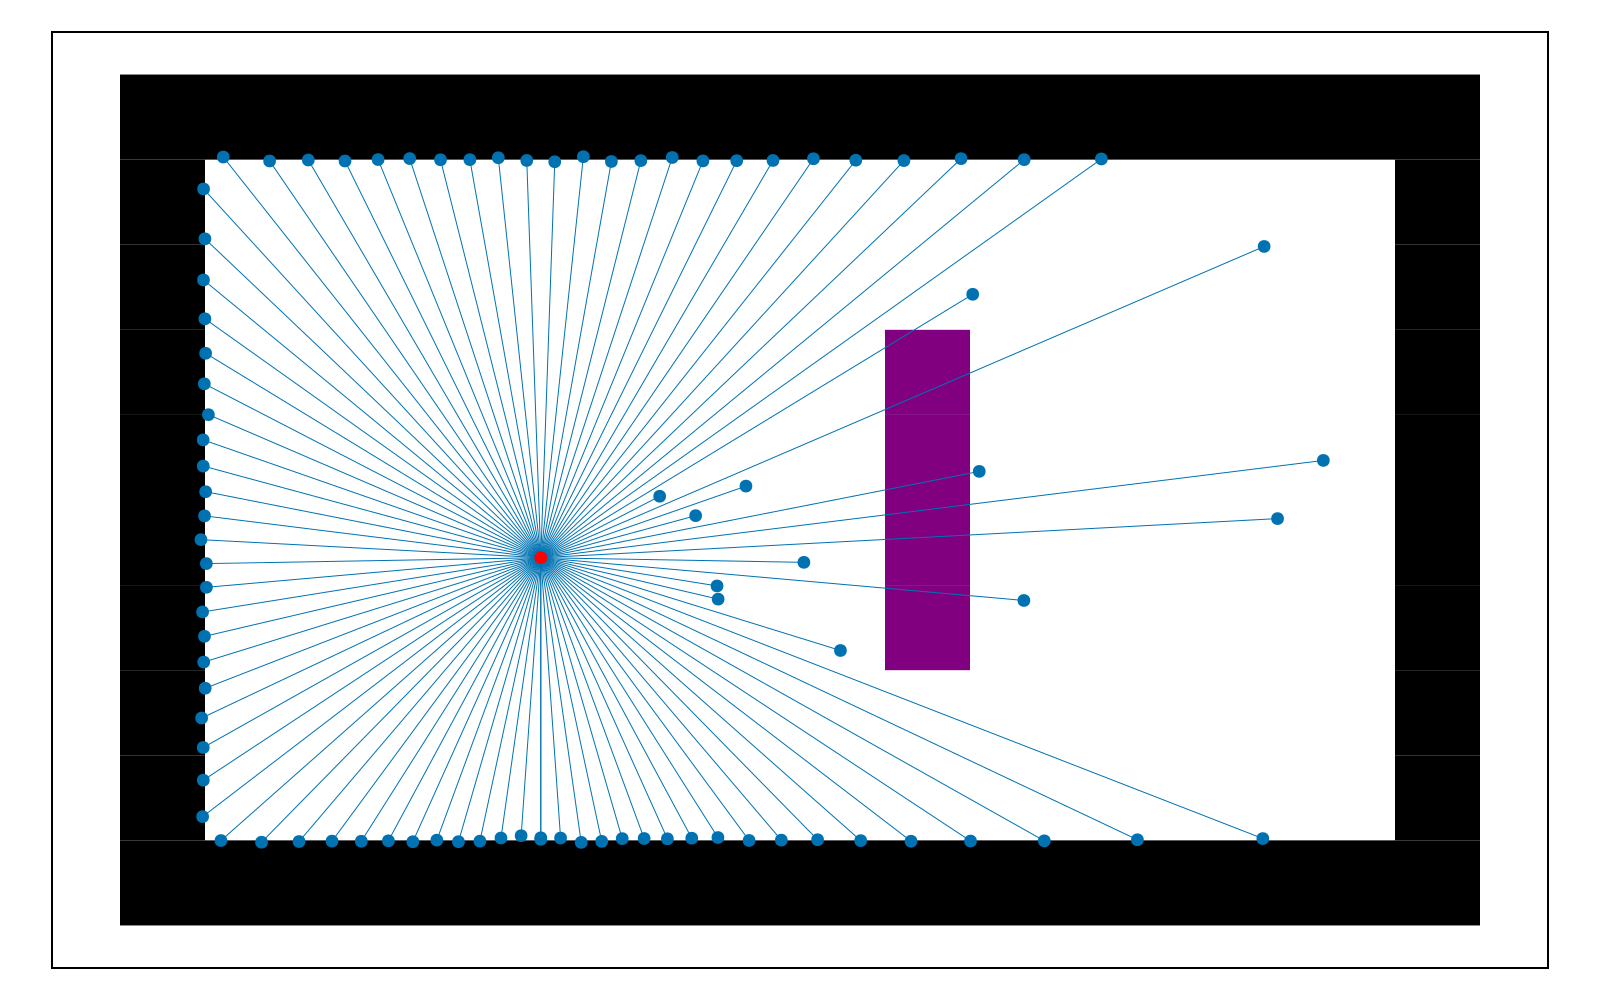

In [53]:
world_trace_st, take_action_st = get_interactive_trace(
    trajectory_model, T_TO_PARAMS_EXPLAIN_STRANGE,
    choicemap((GenPOMDPs.state_addr(0, :cell), (5, 5)))  
);

f = GridWorlds.Viz.mapviz_stillframe(
    T_TO_PARAMS_EXPLAIN_STRANGE(0).map,
    get_posobs_seq(world_trace_st)[][1][1],
    get_posobs_seq(world_trace_st)[][2][1],
    show_map=true
)
Makie.save("010_explain_strange_map.pdf", f)
f

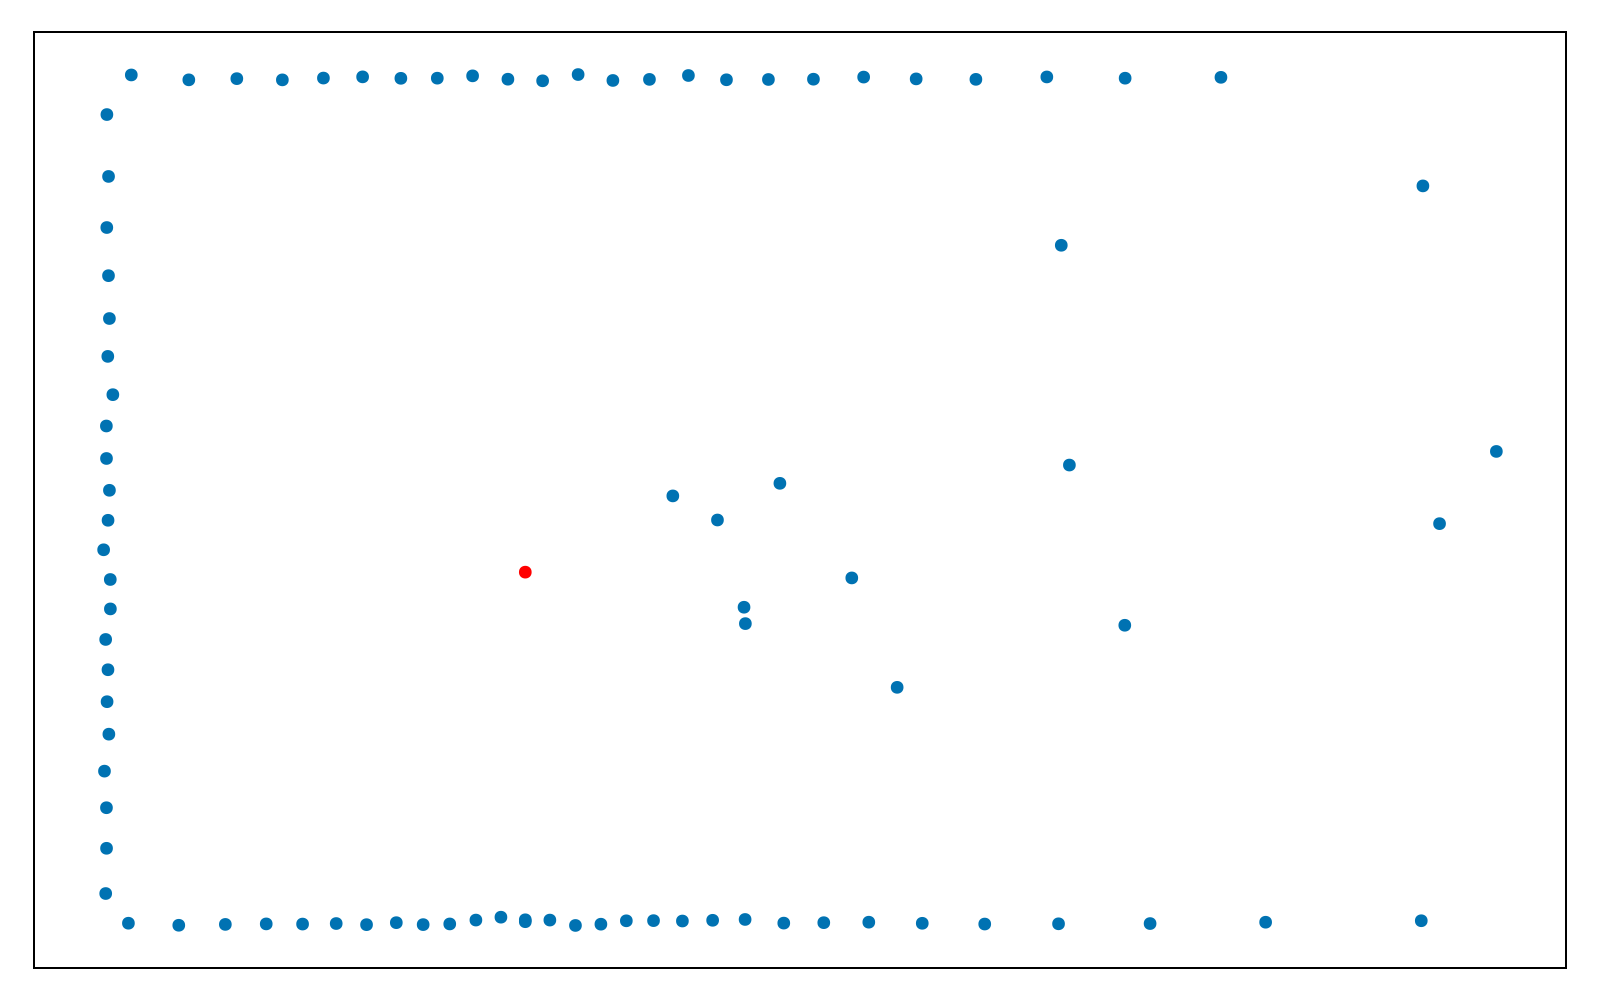

In [54]:
f = GridWorlds.Viz.mapviz_stillframe(
    T_TO_PARAMS_EXPLAIN_STRANGE(0).map,
    get_posobs_seq(world_trace_st)[][1][1],
    get_posobs_seq(world_trace_st)[][2][1],
    show_map=false,
    show_lines_to_walls=false
)
Makie.save("011_explain_strange_agent_view.pdf", f)
f

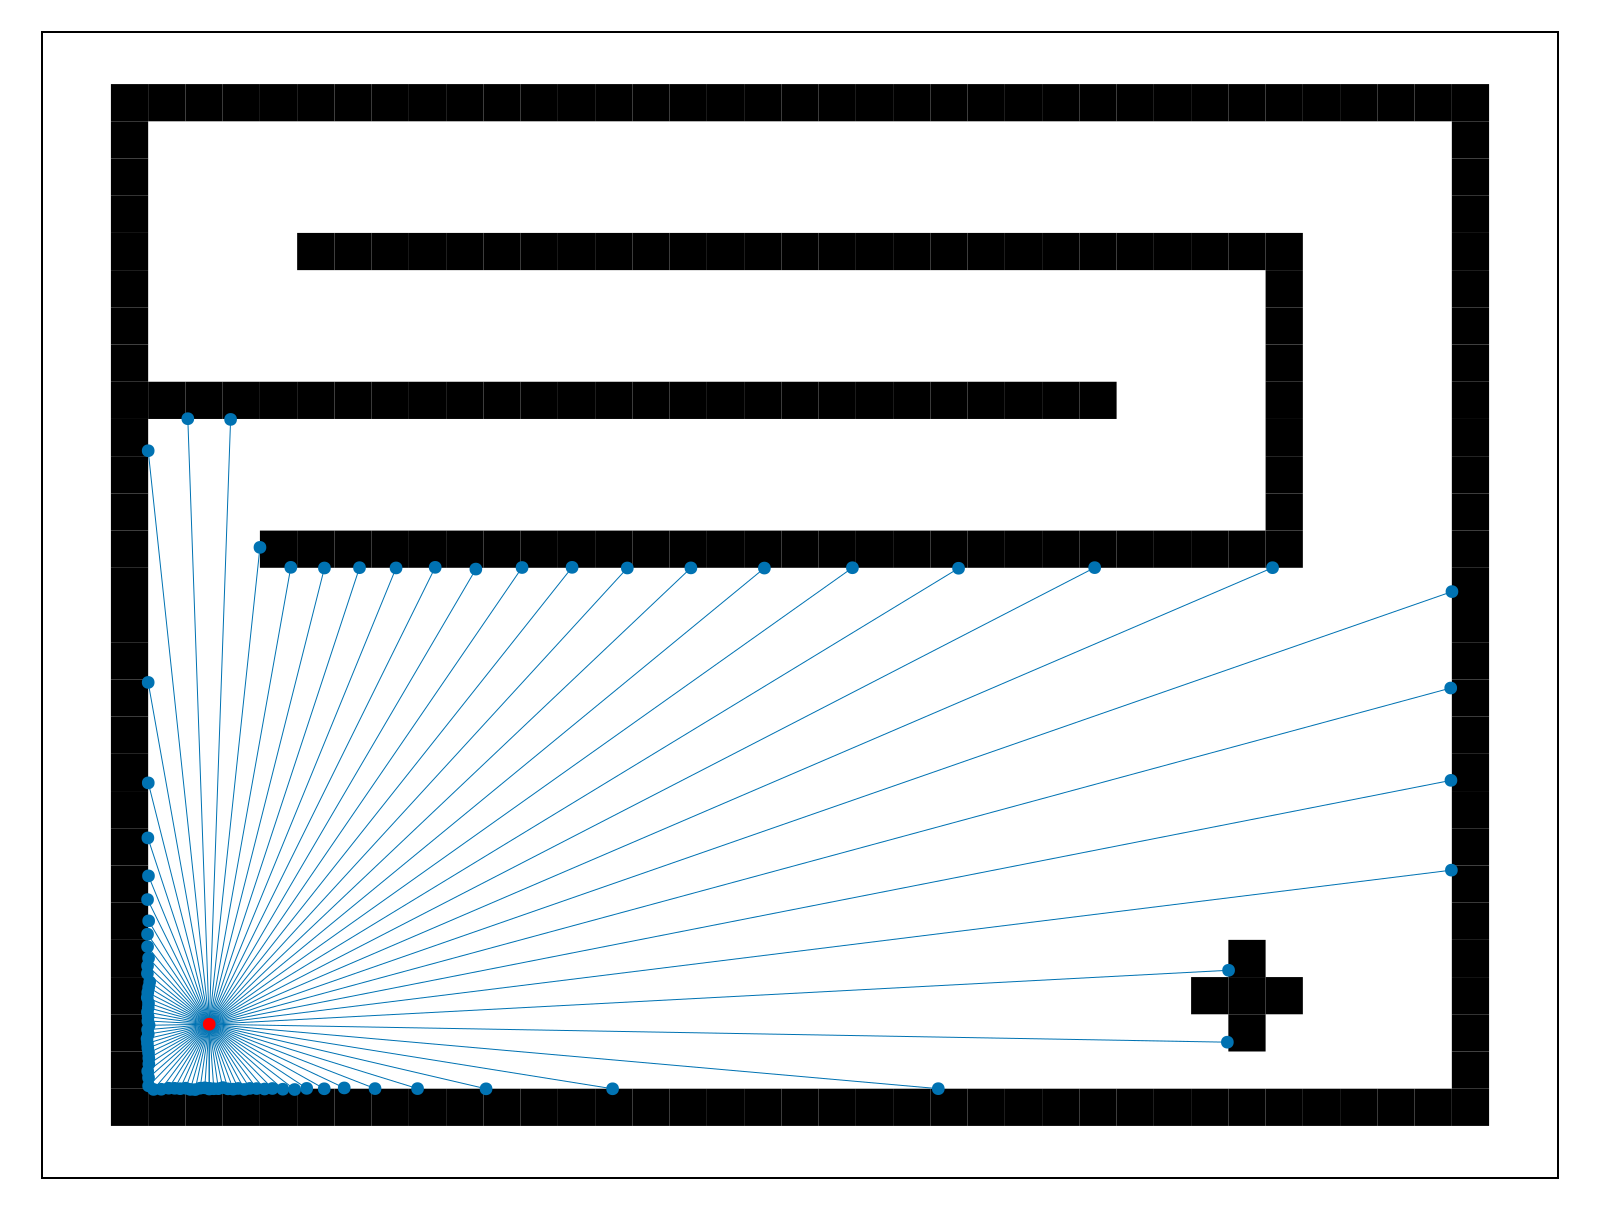

In [78]:
world_trace_l, take_action_l = get_interactive_trace(
    trajectory_model, T_TO_PARAMS_LEARN_MAP,
    choicemap((GenPOMDPs.state_addr(0, :cell), (3, 3)))  
);

f = GridWorlds.Viz.mapviz_stillframe(
    T_TO_PARAMS_LEARN_MAP(0).map,
    get_posobs_seq(world_trace_l)[][1][1],
    get_posobs_seq(world_trace_l)[][2][1],
    show_map=true,
    # show_lines_to_walls=false,
    # show_obs=false,
    # show_pos=false
)
Makie.save("020_learn_map_map.pdf", f)
f

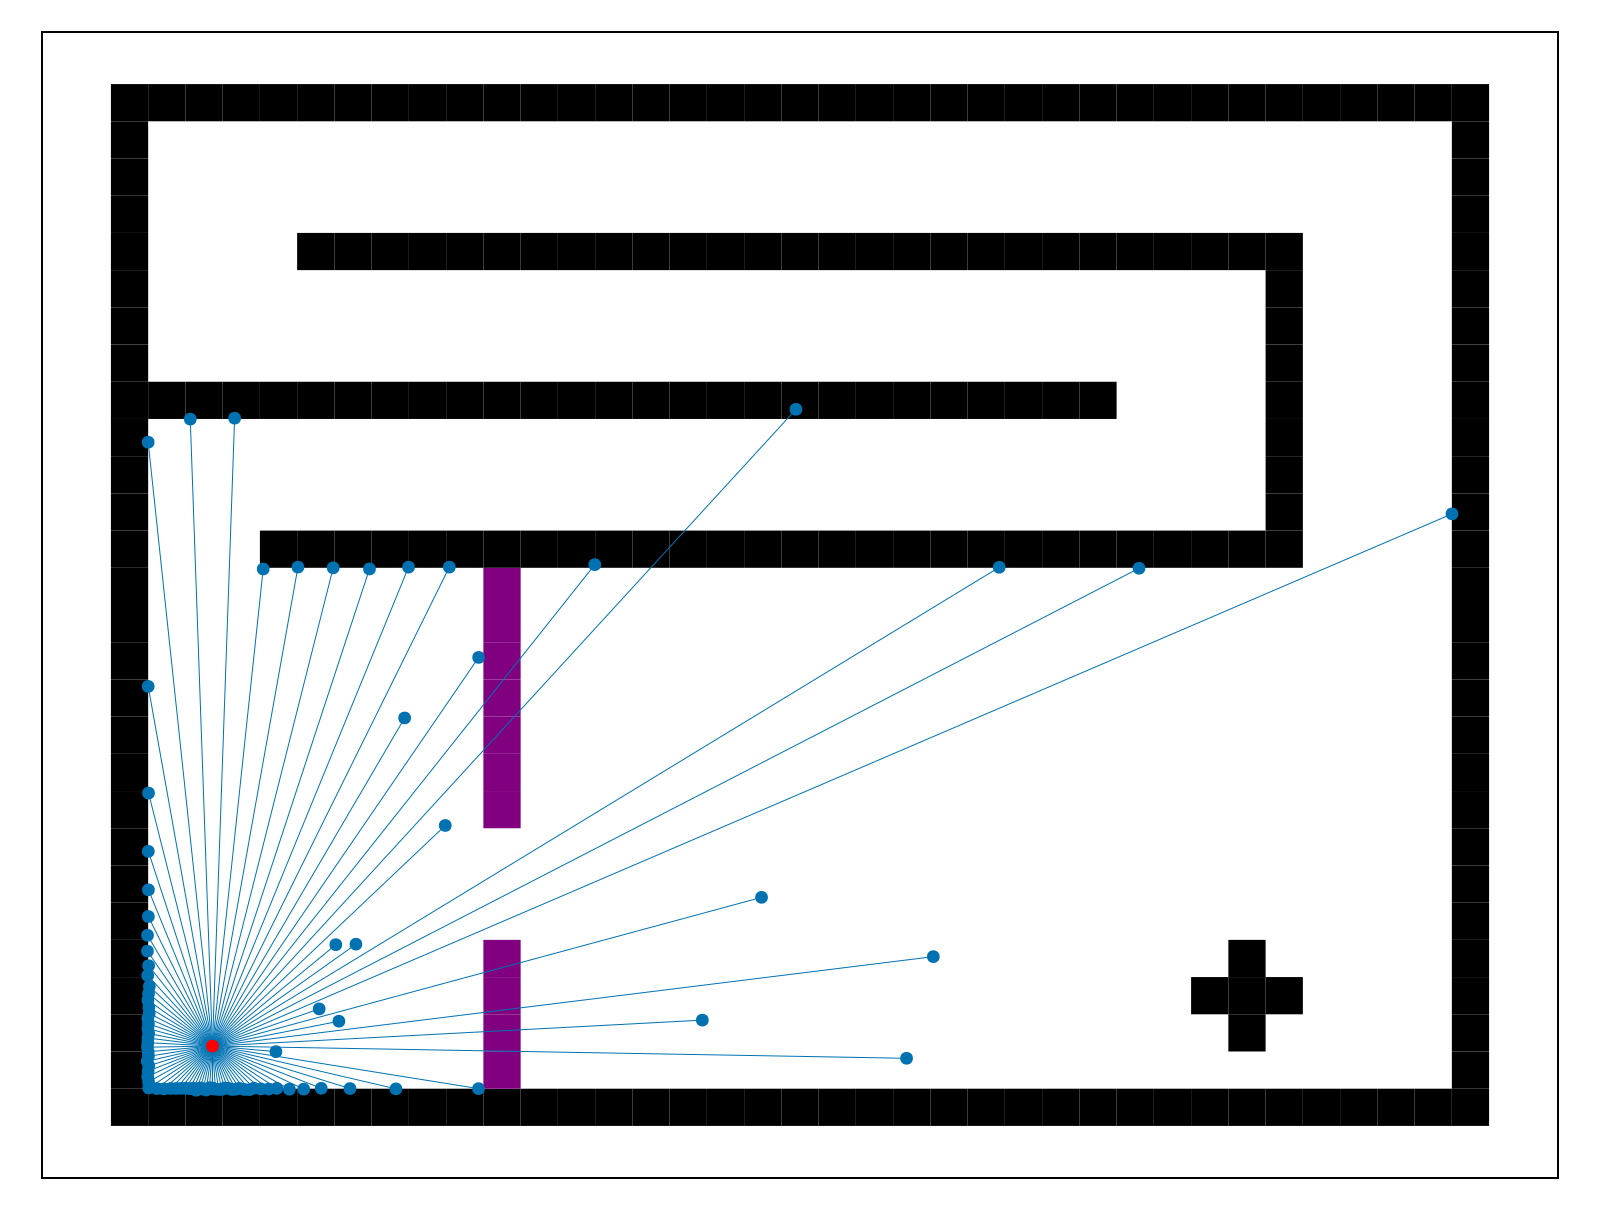

In [74]:
world_trace_test1, take_action_test1 = get_interactive_trace(
    trajectory_model, T_TO_PARAMS_TEST1MAP,
    choicemap((GenPOMDPs.state_addr(0, :cell), (3, 3)))
);

f = GridWorlds.Viz.mapviz_stillframe(
    T_TO_PARAMS_TEST1MAP(0).map,
    get_posobs_seq(world_trace_test1)[][1][1],
    get_posobs_seq(world_trace_test1)[][2][1],
    show_map=true,
    show_lines_to_walls=true,
)
Makie.save("022_test1_map.pdf", f)
f

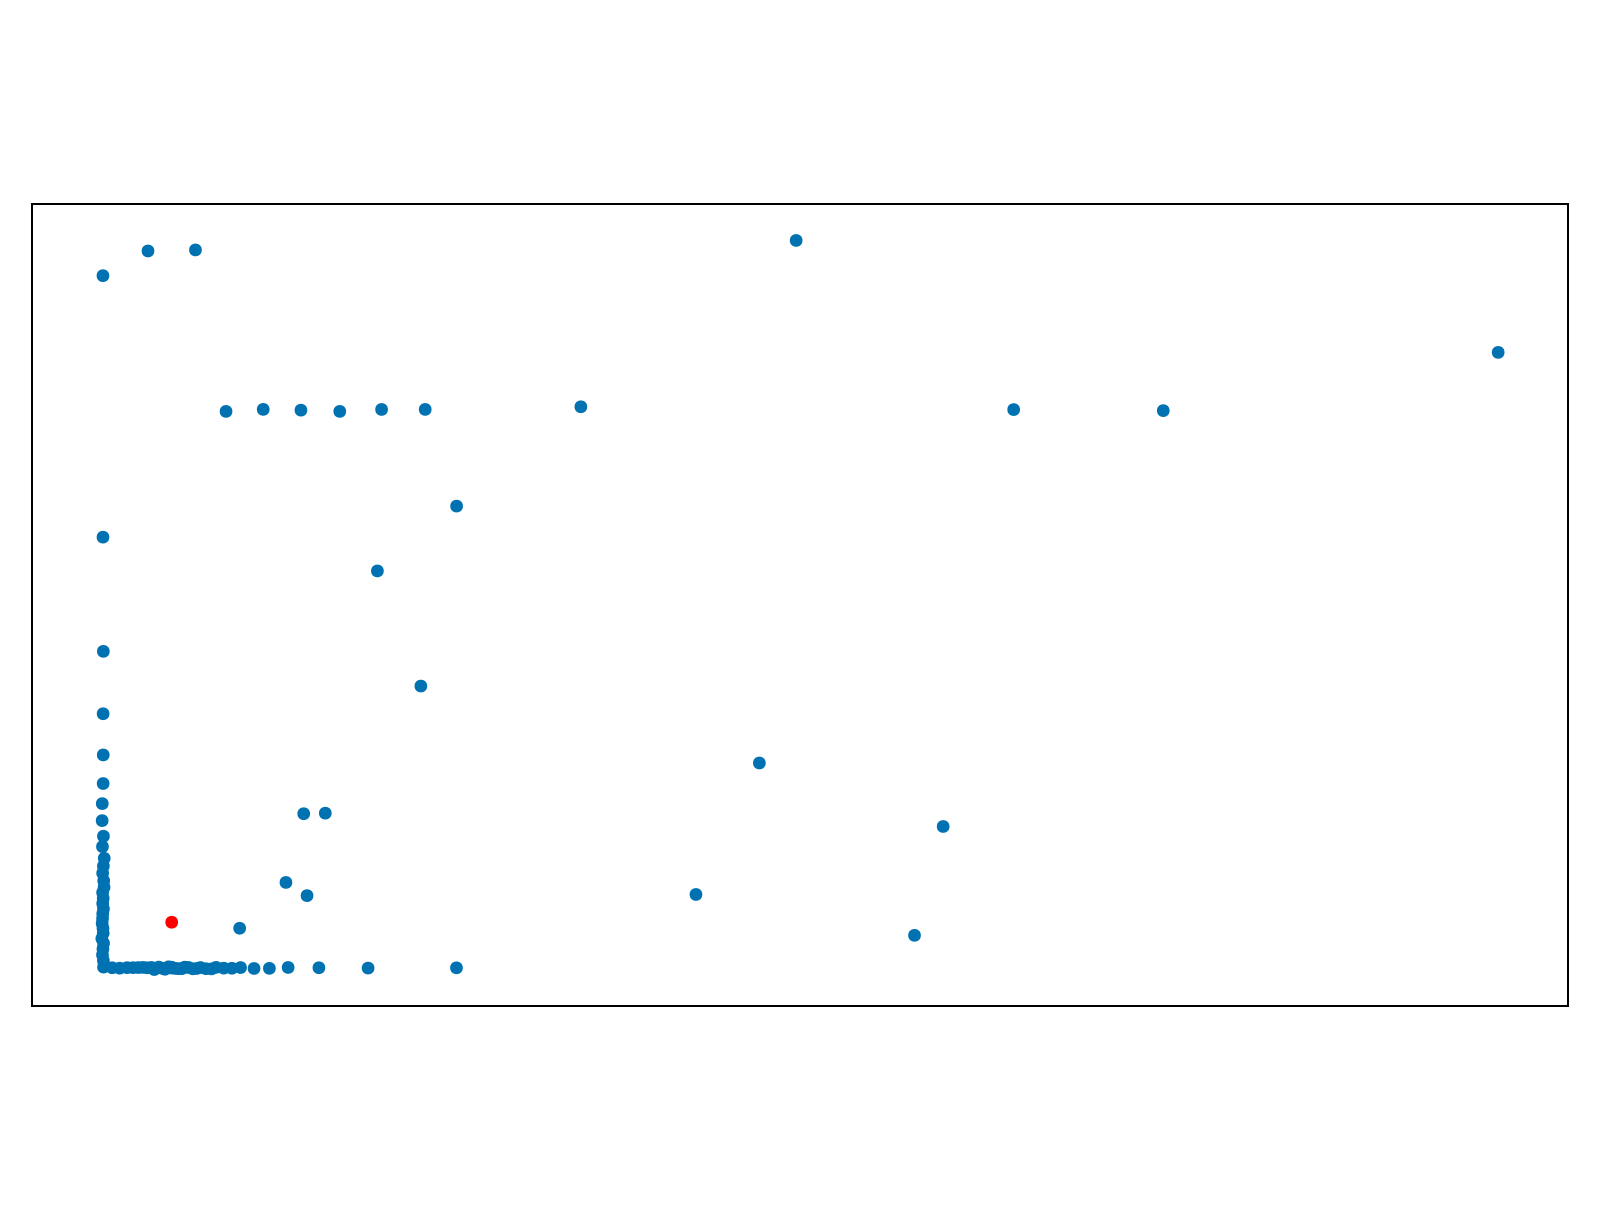

In [85]:
# world_trace_test1, take_action_test1 = get_interactive_trace(
#     trajectory_model, T_TO_PARAMS_TEST1MAP,
#     choicemap((GenPOMDPs.state_addr(0, :cell), (3, 3)))
# );

f = GridWorlds.Viz.mapviz_stillframe(
    T_TO_PARAMS_TEST1MAP(0).map,
    get_posobs_seq(world_trace_test1)[][1][1],
    get_posobs_seq(world_trace_test1)[][2][1],
    show_map=false,
    show_lines_to_walls=false
)
Makie.save("023_test1_obs.pdf", f)
f

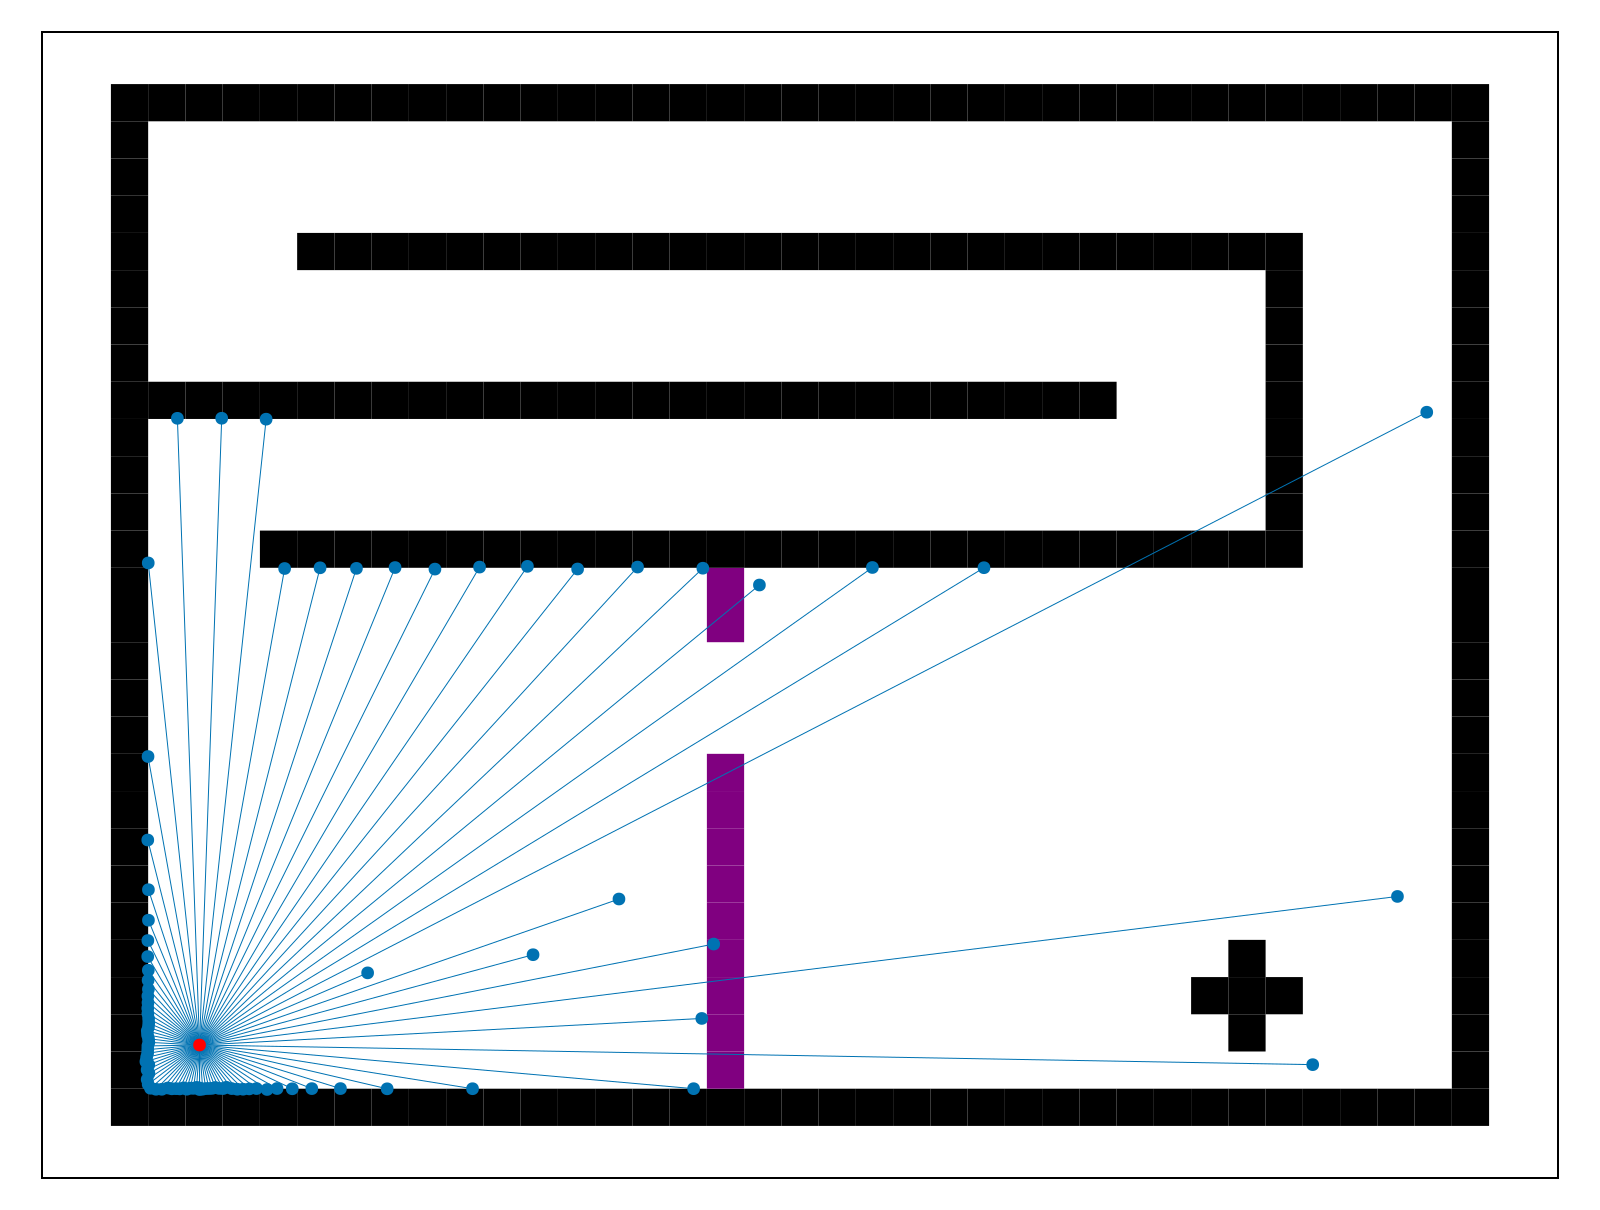

In [77]:
world_trace_test2, take_action_test2 = get_interactive_trace(
    trajectory_model, T_TO_PARAMS_TEST2MAP,
    choicemap((GenPOMDPs.state_addr(0, :cell), (3, 3)))
);

f = GridWorlds.Viz.mapviz_stillframe(
    T_TO_PARAMS_TEST2MAP(0).map,
    get_posobs_seq(world_trace_test2)[][1][1],
    get_posobs_seq(world_trace_test2)[][2][1],
    show_map=true,
    show_lines_to_walls=true,
    # show_pos=false,
    # show_obs=false
)
Makie.save("024_test2_map.pdf", f)
f